In [0]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
from matplotlib import cm
import matplotlib.patches as mpatches

Noisydata = True
stdev = 0.1

data = np.array(np.arange(0, math.pi*2 + 0.1, 0.1))
data_test = np.array(np.arange(0.05, math.pi*2+0.1, 0.1))


#data += gaussvec 
#data_test += gaussvec 

x_data = np.transpose([data])
x_data_test = np.transpose([data_test])

# Sin
def sinFunc(x):
  return np.sin(2*x) + np.random.normal(0,0.1,1) # Add Gauss noise

if(Noisydata):
  y_sinData = sinFunc(x_data) + np.transpose([np.random.normal(0,stdev,len(x_data))]) 
  y_sinData_test = sinFunc(x_data_test) + np.transpose([np.random.normal(0,stdev,len(x_data_test))]) 
else:
  y_sinData = sinFunc(x_data)
  y_sinData_test = sinFunc(x_data_test) 


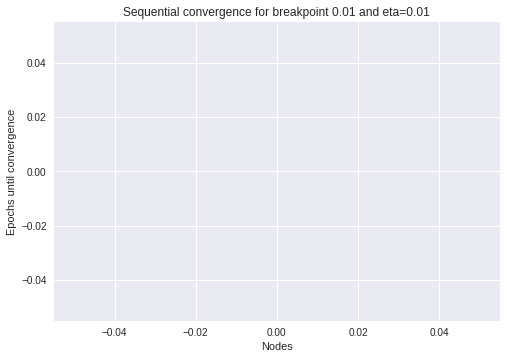

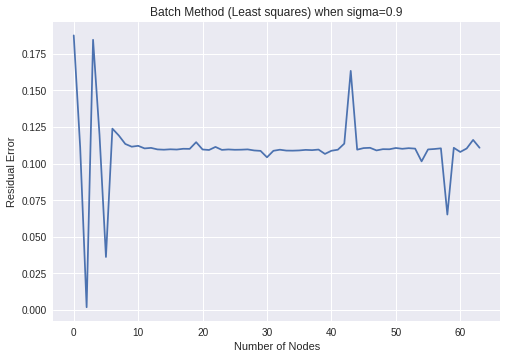

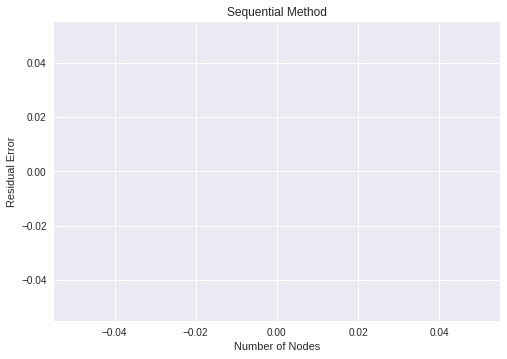

<function matplotlib.pyplot.show>

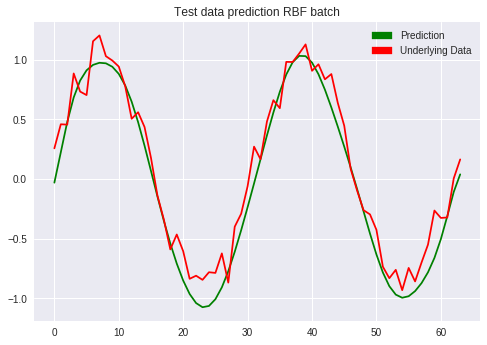

In [3]:
#testing variables
meanRBFSelection = False
smartSigma = False
batchTest = True
breakpoint = 0.001
eta = 0.01


N_RBFNodes = 64

# Change this to change data
dataUsed = x_data
targetUsed = y_sinData

nodesIn = np.shape(dataUsed)[1]
nodesOut = np.shape(targetUsed)[1]

nDataPoints = len(dataUsed)
nDataPoints_Range = range(nDataPoints)


p_error = []
p_errorTest = []

p_errorInc = []
p_errorIncTest = []
indexappend  =[]
# Uncomment here to loop through different type of nodes
for i in range(N_RBFNodes):
#if(True):
  RBFNodes = N_RBFNodes 
  # and uncomment this as well
  RBFNodes = i + 1

  hidden = np.zeros((nDataPoints,RBFNodes))
  hidden_test = np.zeros((len(x_data_test),RBFNodes))
  weights = np.zeros((nodesIn,RBFNodes))


  # Size of sigma controls the width of the gaussian. Large = Neuron responds to every input, smaller = narrower receptive field
  if(smartSigma):
    d = (dataUsed.max()-dataUsed.min()).max()
    sigma = d/np.sqrt(2*RBFNodes) 
  else:
    sigma = 0.9

  steps = nDataPoints / RBFNodes
 
  mu = np.zeros(RBFNodes)

  if(meanRBFSelection):
    for i in range(RBFNodes):
      index = 0
      avg = 0
      for j in range(steps):
        avg = dataUsed[j + i * steps]

      mu[i] = avg/steps
      avg = 0
  else:
    np.random.shuffle(nDataPoints_Range)
    for i in range(RBFNodes):
      mu[i] = dataUsed[nDataPoints_Range[i]]

  #Gauss
  for i in range(RBFNodes):
    hidden[:,i] = np.exp((-(np.transpose(dataUsed)-mu[i])**2)/(2*sigma**2)) 
    hidden_test[:,i] = np.exp((-(np.transpose(x_data_test)-mu[i])**2)/(2*sigma**2))
    
  #Testset
  

  if(batchTest):
    # (given that the data points are randomly shuffled in each epoch).  
    #LEAST SQUARES
    A = np.matmul(np.transpose(hidden),hidden)
    b = np.matmul(np.transpose(hidden),targetUsed)
    w = np.linalg.solve(A,b)
    #Checking error
    #Output
    
    training_out = np.matmul(hidden,w)
    
    test_out = np.matmul(hidden_test,w)

    error = np.sqrt(np.mean((training_out-targetUsed))**2)
    error_test = np.sqrt(np.mean((test_out-y_sinData_test))**2)
    p_error.append(error)
    p_errorTest.append(error_test)

    
    
  ###### DELTARULE INCREMENTAL LOOP THROUGH ROWS OF HIDDEN
  else:
    
    for k in range(nDataPoints):
      e =(targetUsed[k]-np.matmul(hidden[k,:],np.transpose(weights)))
      deltaW = eta*e*hidden[k,:]

      weights=weights+deltaW

      #print("Err incr")
      error_incremental = np.sqrt(np.mean((np.matmul(hidden,np.transpose(weights))-targetUsed))**2)
      error_incremental_test = np.sqrt(np.mean((np.matmul(hidden_test,np.transpose(weights))-y_sinData_test))**2)

      p_errorInc.append(error_incremental)
      p_errorIncTest.append(error_incremental)
      
      #Reaching breakpoint
      
      if error_incremental_test < breakpoint:
        break
      
      training_out = np.matmul(hidden,np.transpose(weights))
    
      test_out = np.matmul(hidden_test,np.transpose(weights))
    indexappend.append(k)
  
        
       
        
      
      
    
      
      
      
      #p_errorIncTest.append(error_incremental_test)
    #print(error_incremental)
    #print(error_incremental_test)

    
plt.figure(1)
plt.plot(indexappend)
plt.title('Sequential convergence for breakpoint 0.01 and eta='+str(eta))
plt.xlabel('Nodes')
plt.ylabel('Epochs until convergence')
plt.show()


plt.figure(2)
plt.plot(p_errorTest)
plt.title('Batch Method (Least squares) when sigma='+str(sigma))
plt.ylabel('Residual Error')
plt.xlabel('Number of Nodes')

#plt.plot(p_errorTest)
plt.show()
plt.figure(3)
plt.plot(p_errorIncTest)
plt.title('Sequential Method')
plt.ylabel('Residual Error')
plt.xlabel('Number of Nodes')
#plt.plot(p_errorIncTest)
plt.show()


plt.figure(4)
plt.plot(test_out, color = 'g')
plt.plot(y_sinData_test,color='r')
plt.title('Test data prediction RBF batch')
green = mpatches.Patch(color='green', label='Prediction')
red = mpatches.Patch(color='red', label='Underlying Data')
plt.legend(handles=[green,red])

plt.show


0.16327355584463124


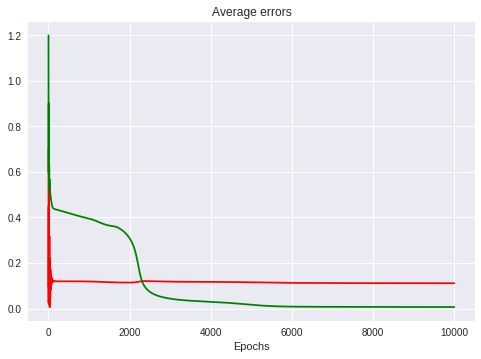

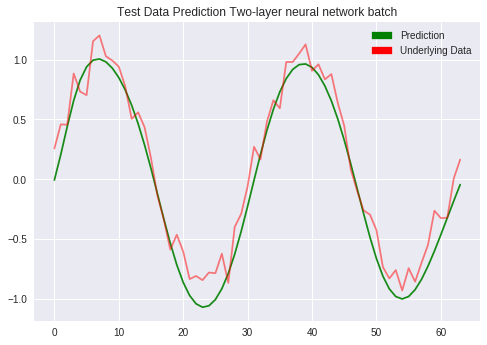

In [9]:
## COMPARISON WITH TWO LAYER NEURAL NETWORK

# Parameters
learning_rate = 0.05
training_epochs = 10000
batch_size = 8
display_step = 100
momentum=0.9
errorEstimation = 0.3


# Defining data for the perceptron

training_x = x_data
test_x = x_data_test

training_y = y_sinData
test_y = y_sinData_test


# Two or three dimensions
NumLayers_Three = True
# Momentum
UseMomentum = True
# Batch or total learn
BatchLearn = False
#Early stopping
earlystop = False

if(BatchLearn):
    batchN = int(len(training_x)/batch_size)
    batchData_X = np.split(training_x,batchN)
    batchData_Y = np.split(training_y,batchN)
    
else:
  batchN = 1
  
# Network Parameters
n_hidden_1 = 4 # 1st layer number of neurons
n_hidden_2 = 4 # 2nd layer number of neurons
n_input = 1    # Data input
n_classes = 1  # Number of classes

# tf Graph input
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
if(NumLayers_Three):
  weights = {
      'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
      'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
      'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
  }
  biases = {
      'b1': tf.Variable(tf.random_normal([n_hidden_1])),
      'b2': tf.Variable(tf.random_normal([n_hidden_2])),
      'out': tf.Variable(tf.random_normal([n_classes]))
  }
else:
  weights = {
      'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
      'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
  }
  biases = {
      'b1': tf.Variable(tf.random_normal([n_hidden_1])),
      'out': tf.Variable(tf.random_normal([n_classes]))
  }


# Create model
def multilayer_perceptron(x):
  if(NumLayers_Three):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x,weights['h1']), biases['b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1,weights['h2']), biases['b2']))
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
  else:
    layer_1 = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
  return out_layer

# Construct model
logits = multilayer_perceptron(X)

# Define loss and optimizer

loss_op = tf.losses.mean_squared_error( labels=Y,predictions=logits)
if(UseMomentum):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum)
else:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    
train_op = optimizer.minimize(loss_op)
valid_op = optimizer.minimize(loss_op)

# Initializing the variables
init = tf.global_variables_initializer()
Global_s=[]

avg_cost_arr = []
final_output_arr1 = []
final_output_arr2 = []
final_output_arr3 = []

training = []
validation = []

saver = tf.train.Saver()

errVal = 0

timePlot = []

if(True):
  with tf.Session() as sess:
      sess.run(init)
     
      # Training cycle
      for epoch in range(training_epochs): #
       
        
        
        if(BatchLearn):
          
          # Loop over all batches
          for i in range(batchN):
              avg_cost = 0
              # Run optimization op (backprop) and cost op (to get loss value) 
              _, c = sess.run([train_op, loss_op], feed_dict={X: batchData_X[i],Y: batchData_Y[i]})
              # Compute average loss
              avg_cost += c / batchN
              
          
        else:
          
          # Do not use batch
          _, c = sess.run([train_op, loss_op], feed_dict={X: training_x,Y: training_y})
          avg_cost = c  #Mean squared error
        
       
        avg_cost_arr.append(avg_cost) 
        
       # if(epoch % display_step == 0 ):
            
        output_validation = sess.run(logits,feed_dict={X: test_x})
        error_validation = np.sqrt(np.mean((output_validation-y_sinData_test))**2)
        
        validation.append(error_validation)
        if (earlystop):
          if(0 < validation[epoch]-validation[epoch-1]) and (epoch>1000) : 
            print("early stop at ", epoch)
            break
       
        
          
      final_output_arr1 = sess.run(logits, feed_dict={X: training_x}) 
      final_output_arr2 = sess.run(logits, feed_dict={X: test_x}) 

plt.figure(1)
plt.plot(validation,'r')
plt.plot(avg_cost_arr,'g')
plt.title('Average errors')
plt.xlabel('Epochs')

    
if(True):


  plt.figure(2)
  plt.plot(final_output_arr2, color='g',alpha=0.9)
  plt.plot(test_y,color='r',alpha=0.5)
  plt.title('Test Data Prediction Two-layer neural network batch')
  green = mpatches.Patch(color='green', label='Prediction')
  red = mpatches.Patch(color='red', label='Underlying Data')
  plt.legend(handles=[green,red])

  ## END OF PLOTTING     
  print(np.sqrt(np.mean((output_validation-test_y)**2)))